In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

import torch
from torchvision import transforms

from torch import nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
path_train = '/content/gdrive/MyDrive/DL/Лаба/train'
path_test = '/content/gdrive/MyDrive/DL/Лаба/test'

### Подготовка данных

создадим список, содержащий имена всех изображений

In [ ]:
rez_trn = os.listdir(path_train)
rez_test = os.listdir(path_test)

Пример изображения

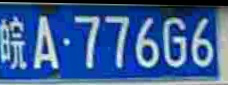

In [ ]:
sample = Image.open(f'{path_train}/{rez_trn[0]}')
sample.show()

Сделаем аугментацию и посмотрим как изменяется изображение

In [ ]:
trans=transforms.Compose([transforms.ToTensor(),
                          transforms.Resize((100, 250)),
                          transforms.ColorJitter(hue=.05, saturation=.05),
                          transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.001, 3)),
                          transforms.RandomRotation(10)
                          ])
sample_t = trans(sample)
sample_t.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 100, 250])

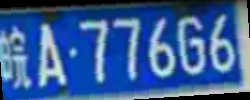

In [ ]:
a = np.array(sample_t)
maxi=a.max()
a=a/maxi*255
a=a.transpose(1,2,0).astype(np.uint8)
b = Image.fromarray(a)
b.show()

Получим таргеты (закодируем каждый уникальный символ)

In [ ]:
trg_trn = [s[-11:-4] for s in rez_trn]
trg_test = [s[-11:-4] for s in rez_test]
trg_trn[0]

'皖A776G6'

In [ ]:
trg_symb_trn = [[i for i in s] for s in trg_trn]
trg_symb_test = [[i for i in s] for s in trg_test]
trg_symb_trn[0]

['皖', 'A', '7', '7', '6', 'G', '6']

In [ ]:
trg_unique_trn = {symb for word in trg_symb_trn for symb in word}
trg_unique_test = {symb for word in trg_symb_test for symb in word}
trg_unique = trg_unique_trn | trg_unique_test
trg_unique

{'0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '云',
 '京',
 '冀',
 '川',
 '新',
 '晋',
 '沪',
 '津',
 '浙',
 '渝',
 '湘',
 '琼',
 '皖',
 '粤',
 '苏',
 '蒙',
 '豫',
 '贵',
 '赣',
 '辽',
 '鄂',
 '闽',
 '陕',
 '青',
 '鲁',
 '黑'}

In [ ]:
target = {symb: idx for idx, symb in enumerate(trg_unique)}
target['C']

45

In [ ]:
print("Всего классов =", len(target))

Всего классов = 60


Кодируем номера

In [ ]:
label_trn = []
buf = []
for x in trg_trn:
  for symb in x:
    buf.append(target[symb])
  label_trn.append(buf)
  buf = []

In [ ]:
label_test = []
buf = []
for x in trg_test:
  for symb in x:
    buf.append(target[symb])
  label_test.append(buf)
  buf = []

In [ ]:
label_trn[10], label_test[10]

([6, 52, 3, 41, 3, 50, 42], [6, 52, 24, 18, 55, 41, 10])

Создадим класс датасет

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, path, file_img, transform, trg):
    super().__init__()
    self.path = path
    self.file_img = file_img
    self.transform = transform
    self.trg = trg

  def __len__(self):
    return len(self.file_img)

  def __getitem__(self, index):
    img_t = self.transform(Image.open(f'{self.path}/{self.file_img[index]}'))

    trg_ind = self.file_img[index][-11:-4]
    trg_ind = [self.trg[s] for s in trg_ind]

    return img_t, trg_ind

Разобьем трейн на трейн и валидацию


In [ ]:
from sklearn import model_selection

In [ ]:
(train_imgs, valid_imgs,) = model_selection.train_test_split(rez_trn, test_size=0.1, random_state=42)

Создадим датасеты

In [ ]:
train_dataset = Dataset(path_train, train_imgs, trans, target)

In [ ]:
valid_dataset = Dataset(path_train, valid_imgs, trans, target)

In [ ]:
test_dataset = Dataset(path_test, trg_trn, trans, target)

Теперь DataLoader

In [ ]:
def collate_fn(batch):
  img = torch.Tensor([el[0].tolist() for el in batch])
  trg = torch.Tensor([el[1] for el in batch])
  return img, trg

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn = collate_fn)

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn = collate_fn)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn = collate_fn)

проверим как выглядит один из элементов

In [ ]:
tmp = next(iter(train_dataloader))

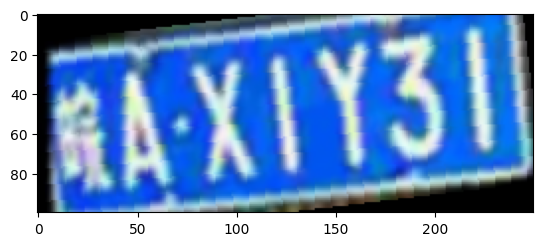

In [ ]:
a = np.array(tmp[0][0])
maxi=a.max()
a=a/maxi*255
a=a.transpose(1,2,0).astype(np.uint8)
b = Image.fromarray(a)
plt.imshow(b)

### Создание и обучение модели

In [ ]:
class OCR(torch.nn.Module):
  def __init__(self, target):
    super().__init__()

    self.conv = torch.nn.Sequential(torch.nn.Conv2d(3, 16, kernel_size=(3,3)),
                                    torch.nn.LeakyReLU(),
                                    torch.nn.BatchNorm2d(num_features=16),
                                    torch.nn.MaxPool2d(kernel_size=(2,2)),

                                    torch.nn.Conv2d(16, 32, kernel_size=(3,3)),
                                    torch.nn.LeakyReLU(),
                                    torch.nn.BatchNorm2d(num_features=32),
                                    torch.nn.MaxPool2d(kernel_size=(2,2)),

                                    torch.nn.Conv2d(32, 64, kernel_size=(3,3)),
                                    torch.nn.LeakyReLU(),
                                    torch.nn.BatchNorm2d(num_features=64),
                                    torch.nn.MaxPool2d(kernel_size=(2,2)),

                                    torch.nn.Conv2d(64, 128, kernel_size=(3,3)),
                                    torch.nn.LeakyReLU(),
                                    torch.nn.BatchNorm2d(num_features=128),
                                    torch.nn.MaxPool2d(kernel_size=(2,2)),

                                    torch.nn.Conv2d(128, 256, kernel_size=(4, 1)),
                                    torch.nn.LeakyReLU(),
                                    torch.nn.BatchNorm2d(num_features=256)
                                    )

    self.fc = torch.nn.Sequential(torch.nn.Linear(64*3*12, 59),
                                  torch.nn.LeakyReLU()
    )

    self.LSTM = torch.nn.LSTM(256, 30, bidirectional=True, num_layers=3)

    self.output = torch.nn.Sequential(torch.nn.Linear(60, target),
                                 torch.nn.LeakyReLU()
    )

  def forward(self, img):
    img = img[0]
    #print(img.shape)
    img = self.conv(img)
    #print(img.shape)
    #img = torch.flatten(img, start_dim=1)
    img = img.squeeze(2)
    img = img.permute(2,0,1)
    #print(img.shape)
    #img = self.fc(img)
    #print(img.shape)
    img, _ = self.LSTM(img)
    #print(img.shape)
    img = self.output(img)
    img = img.permute(1,0,2)
    #print(img.shape)
    return img

In [ ]:
model = OCR(len(target))
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
model

OCR(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): BatchNorm2d(12

Определим функции train и eval

In [ ]:
from tqdm import tqdm

In [ ]:
def train_fn(model, data_loader, optimizer):
    model.train()
    fin_loss = 0

    for data in tqdm(data_loader):
        optimizer.zero_grad()

        output = model(data)

        output = output.permute(1, 0, 2)

        log_probs = F.log_softmax(output, 2)
        targets = data[1]

        input_lengths = torch.full(size=(8,), fill_value=log_probs.size(0), dtype=torch.int32)

        target_lengths = torch.full(size=(8,), fill_value=targets.size(1), dtype=torch.int32)

        loss = nn.CTCLoss(blank=0)(log_probs, targets, input_lengths, target_lengths)


        loss.backward()
        optimizer.step()

        fin_loss += loss.item()


    return fin_loss / len(data_loader)

In [ ]:
def eval_fn(model, data_loader):
    model.eval()
    fin_loss = 0

    fin_preds = []
    i = 0
    with torch.no_grad():
        for data in tqdm(data_loader):

            output = model(data)

            output = output.permute(1, 0, 2)

            log_probs = F.log_softmax(output, 2)
            targets = data[1]

            input_lengths = torch.full(size=(8,), fill_value=log_probs.size(0), dtype=torch.int32)

            target_lengths = torch.full(size=(8,), fill_value=targets.size(1), dtype=torch.int32)

            loss = nn.CTCLoss(blank=0)(log_probs, targets, input_lengths, target_lengths)

            fin_loss += loss.item()

            fin_preds.append(output)
            if i == 11:
              break
            i+=1

    return fin_preds, fin_loss / len(data_loader)

Определим декодер

Функция удаления повторных символов

In [ ]:
def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    return fin

Функция, которая из словаря по значению возвращает ключ

In [ ]:
def reverse(target, ind):
  for key in target:
    if target[key] == ind:
      return key

функция декодинга

In [ ]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    #выбираем наиболее вероятных символ по предсказаниям
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()

    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            p = encoder(target, k)
            temp.append(p)

        temp = "".join(temp)
        temp = remove_duplicates(temp)
        cap_preds.append(temp)
    return cap_preds


In [ ]:
from sklearn import metrics

In [ ]:
(train_num_imgs, valid_num_imgs,) = model_selection.train_test_split(trg_trn, test_size=0.1, random_state=42)

In [ ]:
epochs = 3
for epoch in range(epochs):

    train_loss = train_fn(model, train_dataloader, optimizer)
    valid_preds, test_loss = eval_fn(model, valid_dataloader)

    valid_number_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, reverse)
        valid_number_preds.extend(current_preds)

    combined = list(zip(valid_num_imgs, valid_number_preds))
    print(combined[:10])

    valid_dup_rem = [remove_duplicates(c) for c in valid_num_imgs]
    accuracy = metrics.accuracy_score(valid_dup_rem, valid_number_preds)

    print(
        f"Epoch={epoch}, Train Loss={train_loss}, Evaluation={test_loss} Accuracy={accuracy}"
    )

    optimizer.step(test_loss)

100%|██████████| 2500/2500 [04:21<00:00,  9.54it/s]


[('皖A6T964', '皖A6T964'), ('皖A08M75', '皖A08M75'), ('皖AWY706', '皖AWY706'), ('皖AX116D', '皖AX16D'), ('皖A9J230', '皖A9J230'), ('皖NPM377', '皖NPM37'), ('皖AB926B', '皖AB926B'), ('皖AX215P', '皖AX215P'), ('皖AB0B59', '皖AB0B59'), ('皖AW6G35', '皖AW6G35')]
Epoch=0, Train Loss=0.015098414474653599, Evaluation=0.00833991790873697 Accuracy=0.9882988298829883


100%|██████████| 2500/2500 [04:21<00:00,  9.57it/s]


[('皖A6T964', '皖A6T964'), ('皖A08M75', '皖A08M75'), ('皖AWY706', '皖AWY706'), ('皖AX116D', '皖AX16D'), ('皖A9J230', '皖A9J230'), ('皖NPM377', '皖NPM37'), ('皖AB926B', '皖AB926B'), ('皖AX215P', '皖AX215P'), ('皖AB0B59', '皖AB0B59'), ('皖AW6G35', '皖AW6G35')]
Epoch=1, Train Loss=0.009843402019266072, Evaluation=0.0057467854574060765 Accuracy=0.9918491849184918


100%|██████████| 2500/2500 [04:21<00:00,  9.57it/s]


[('皖A6T964', '皖A6T964'), ('皖A08M75', '皖A08M75'), ('皖AWY706', '皖AWY706'), ('皖AX116D', '皖AX16D'), ('皖A9J230', '皖A9J230'), ('皖NPM377', '皖NPM37'), ('皖AB926B', '皖AB926B'), ('皖AX215P', '皖AX215P'), ('皖AB0B59', '皖AB0B59'), ('皖AW6G35', '皖AW6G35')]
Epoch=2, Train Loss=0.007830326208543037, Evaluation=0.0045487869668773785 Accuracy=0.9937993799379938


Сохраняем полученную модель

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/model.pt')

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/model.pt'))

<All keys matched successfully>

### Подсчет метрик

получим предсказания на тесте

In [ ]:
test_preds, test_loss = eval_fn(model, test_dataloader)

100%|██████████| 1250/1250 [02:19<00:00,  8.95it/s]


In [ ]:
number_preds = []

for vp in test_preds:
        current_preds = decode_predictions(vp, reverse)
        number_preds.extend(current_preds)

combined = list(zip(trg_test, number_preds))
print(combined[:10])

[('皖A96Z09', '皖A96Z09'), ('皖NY667C', '皖NY667C'), ('皖AJ915C', '皖A916C'), ('皖A7X333', '皖A7X333'), ('皖AZJ159', '皖AZJ159'), ('皖AB5W66', '皖AB5W66'), ('皖AL7A65', '皖AL7A65'), ('皖AD817D', '皖AD817D'), ('皖AVW733', '皖AVW733'), ('皖AZA213', '皖AZA213')]


посчитаем accuracy

In [ ]:
metrics.accuracy_score(trg_test, number_preds)

0.9707970797079708

посчитаем Character Error Rate

In [ ]:
import torchmetrics

In [ ]:
torchmetrics.functional.char_error_rate(number_preds, trg_test)

tensor(0.0055)

### Анализ ошибок модели

In [ ]:
import pandas as pd

In [ ]:
img_name, ocr_output = zip(*combined)

In [ ]:
df_output = pd.DataFrame({'img_name' : img_name, 'ocr_output' : ocr_output})

In [ ]:
df_output.head()

,img_name,ocr_output
0,皖A96Z09,皖A96Z09
1,皖NY667C,皖NY667C
2,皖AJ915C,皖A916C
3,皖A7X333,皖A7X333
4,皖AZJ159,皖AZJ159


In [ ]:
df_output.shape[0]

9999

In [ ]:
df_output['cer'] = ''

for i in range(df_output.shape[0]):
  ref = df_output.loc[i, 'img_name']
  output = df_output.loc[i, 'ocr_output']
  df_output.loc[i, 'cer'] = torchmetrics.functional.char_error_rate(output, ref)

In [ ]:
df_output.head()

,img_name,ocr_output,cer
0,皖A96Z09,皖A96Z09,tensor(0.)
1,皖NY667C,皖NY667C,tensor(0.)
2,皖AJ915C,皖A916C,tensor(0.2857)
3,皖A7X333,皖A7X333,tensor(0.)
4,皖AZJ159,皖AZJ159,tensor(0.)


посмотрим на самые ошибочные случаи

In [ ]:
df_output.sort_values(
        by = ["cer"],
        ascending = False )[:50]

,img_name,ocr_output,cer
5782,皖AK927W,皖ZZ,tensor(0.8571)
8342,皖ASW824,渝GW43,tensor(0.8571)
4487,皖AF888S,皖AT99,tensor(0.7143)
6998,皖AN8N55,皖AFF,tensor(0.7143)
4492,皖A2W003,皖A2G332,tensor(0.5714)
7284,皖APY862,皖A9PV8Z,tensor(0.5714)
2781,皖AMQ059,皖A0G39,tensor(0.5714)
9619,皖AZ7M69,皖AQ119,tensor(0.5714)
4913,皖AY915C,皖AX9SC,tensor(0.4286)
108,皖AW968W,皖AK68,tensor(0.4286)


In [ ]:
err = list(df_output.sort_values(
        by = ["cer"],
        ascending = False )[:50]['img_name'])

In [ ]:
test_image_files = os.listdir(path_test)

In [ ]:
err_pic = []

for i in err:
  for j in test_image_files:
    if j.find(i)!=-1:
      err_pic.append(j)
      break

посмотрим, что могло пойти не так

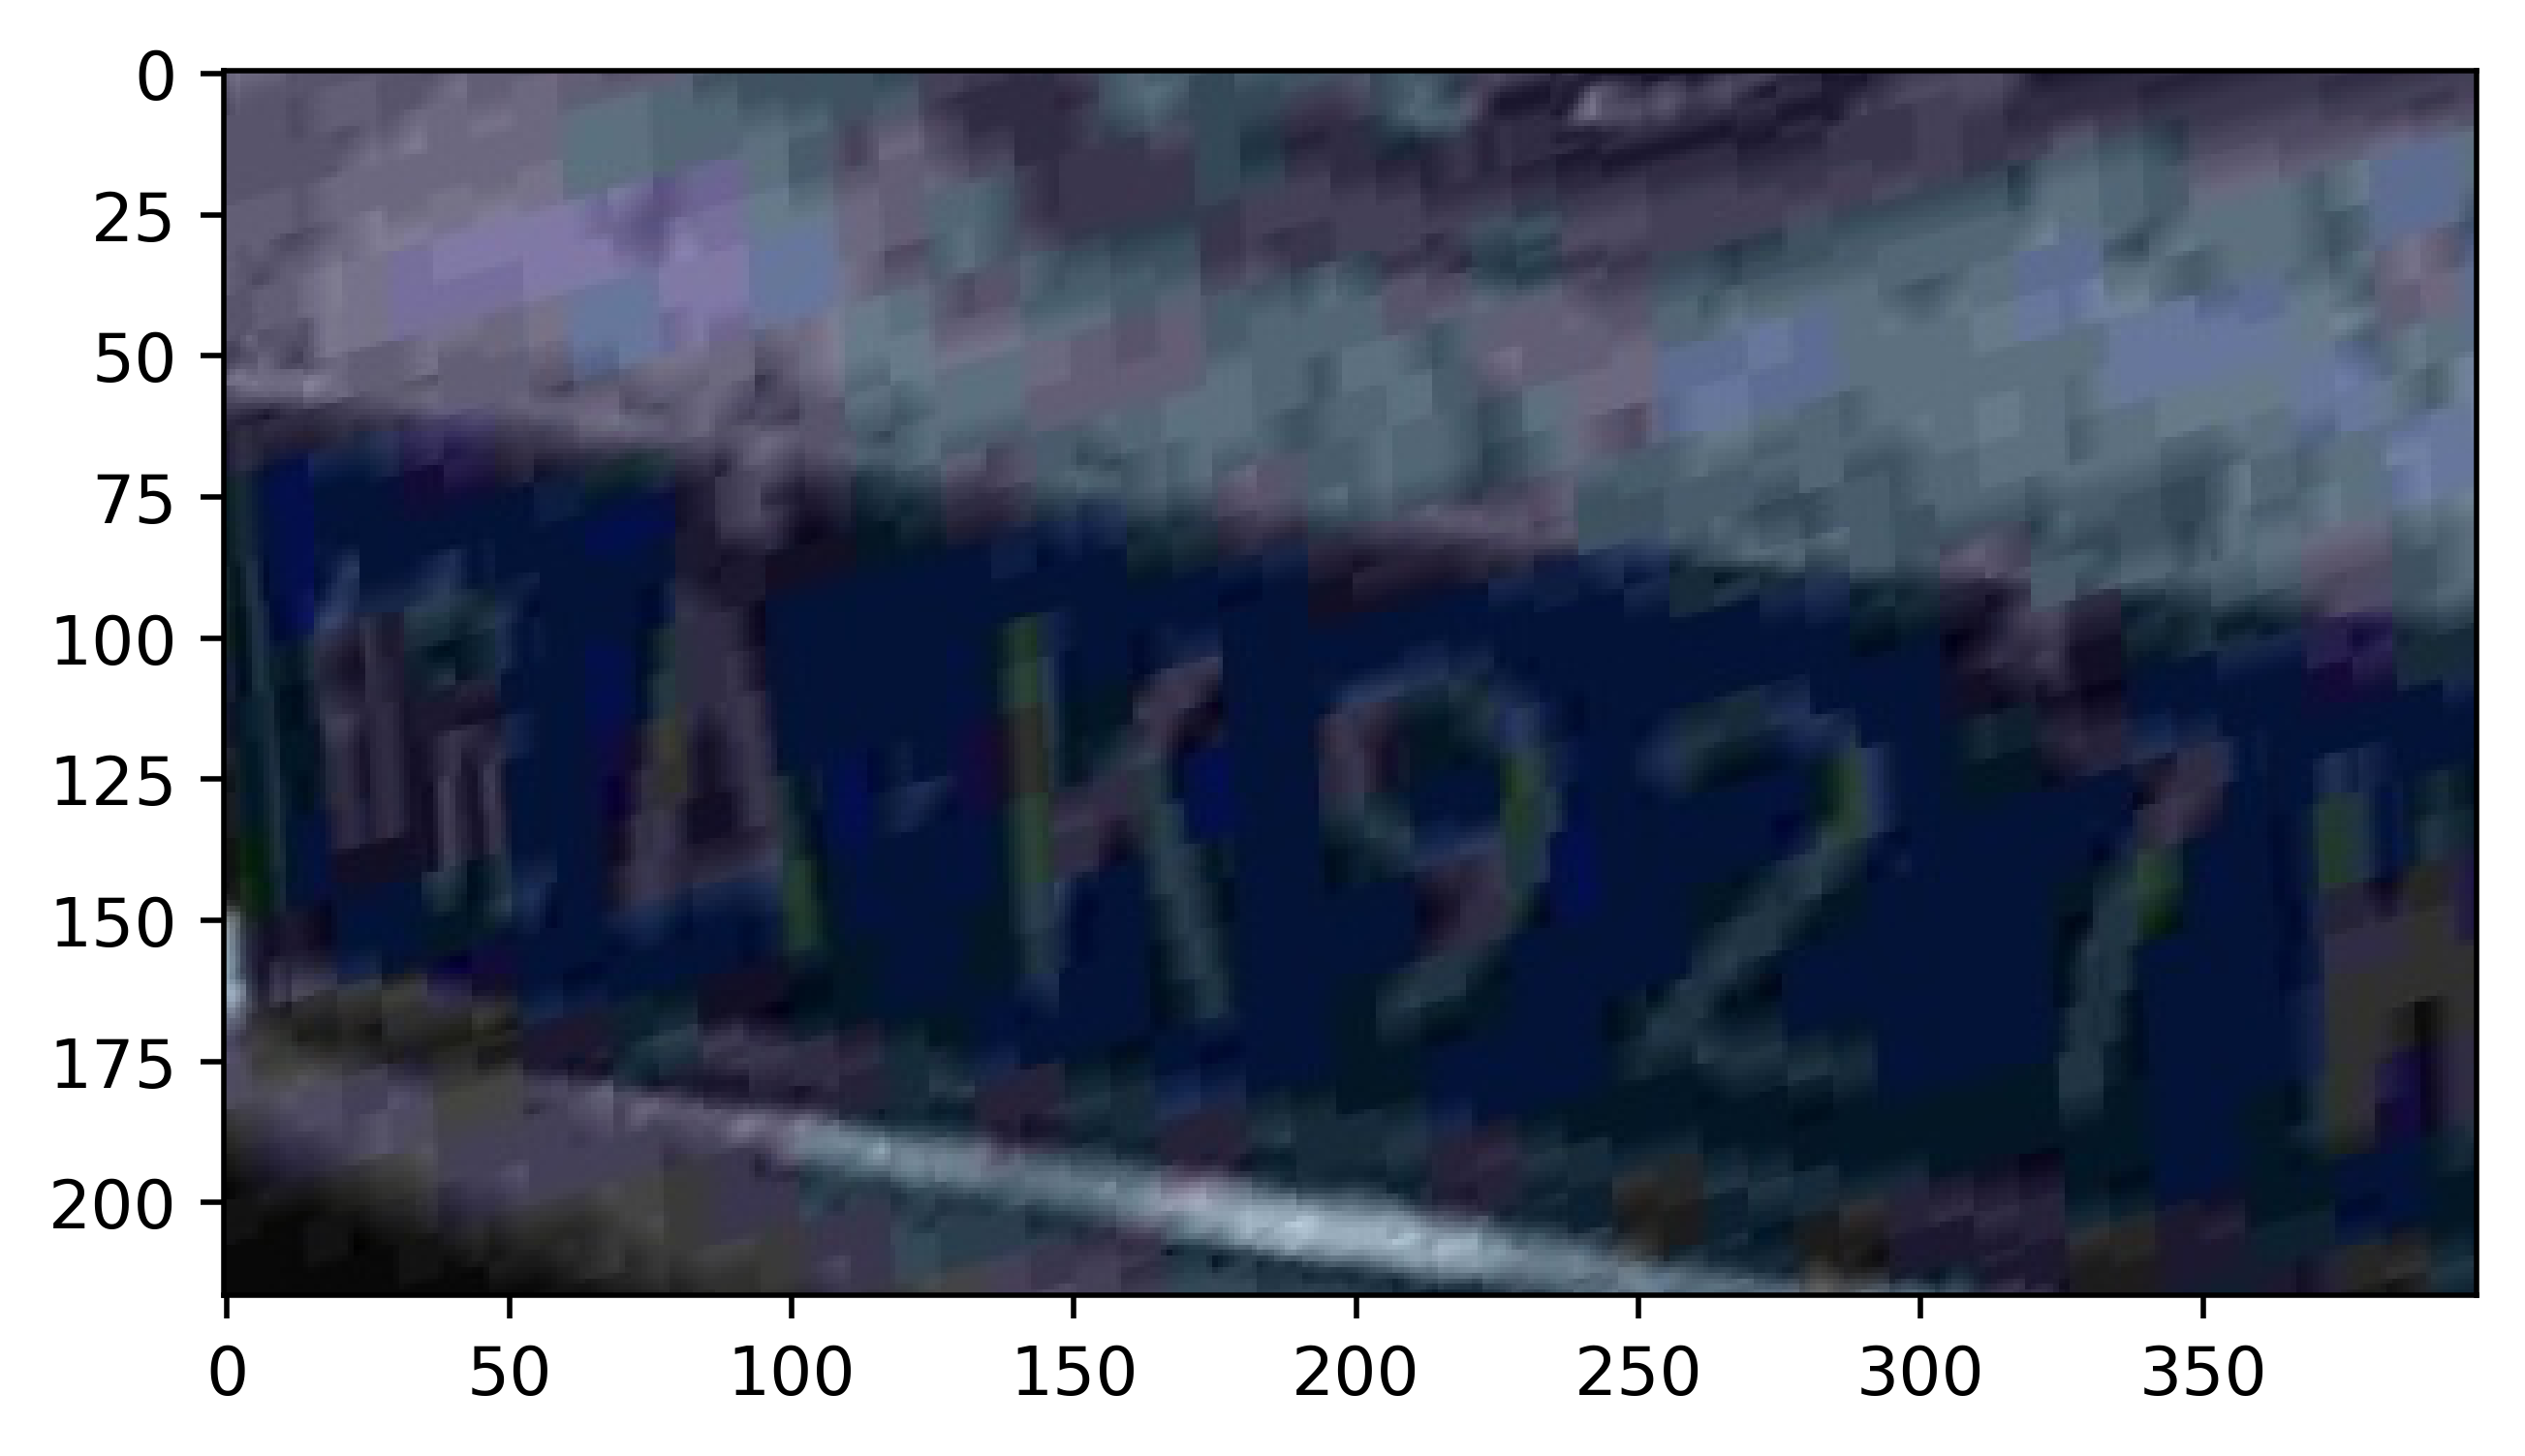

In [ ]:
plt.imshow(Image.open(err_pic[0]))

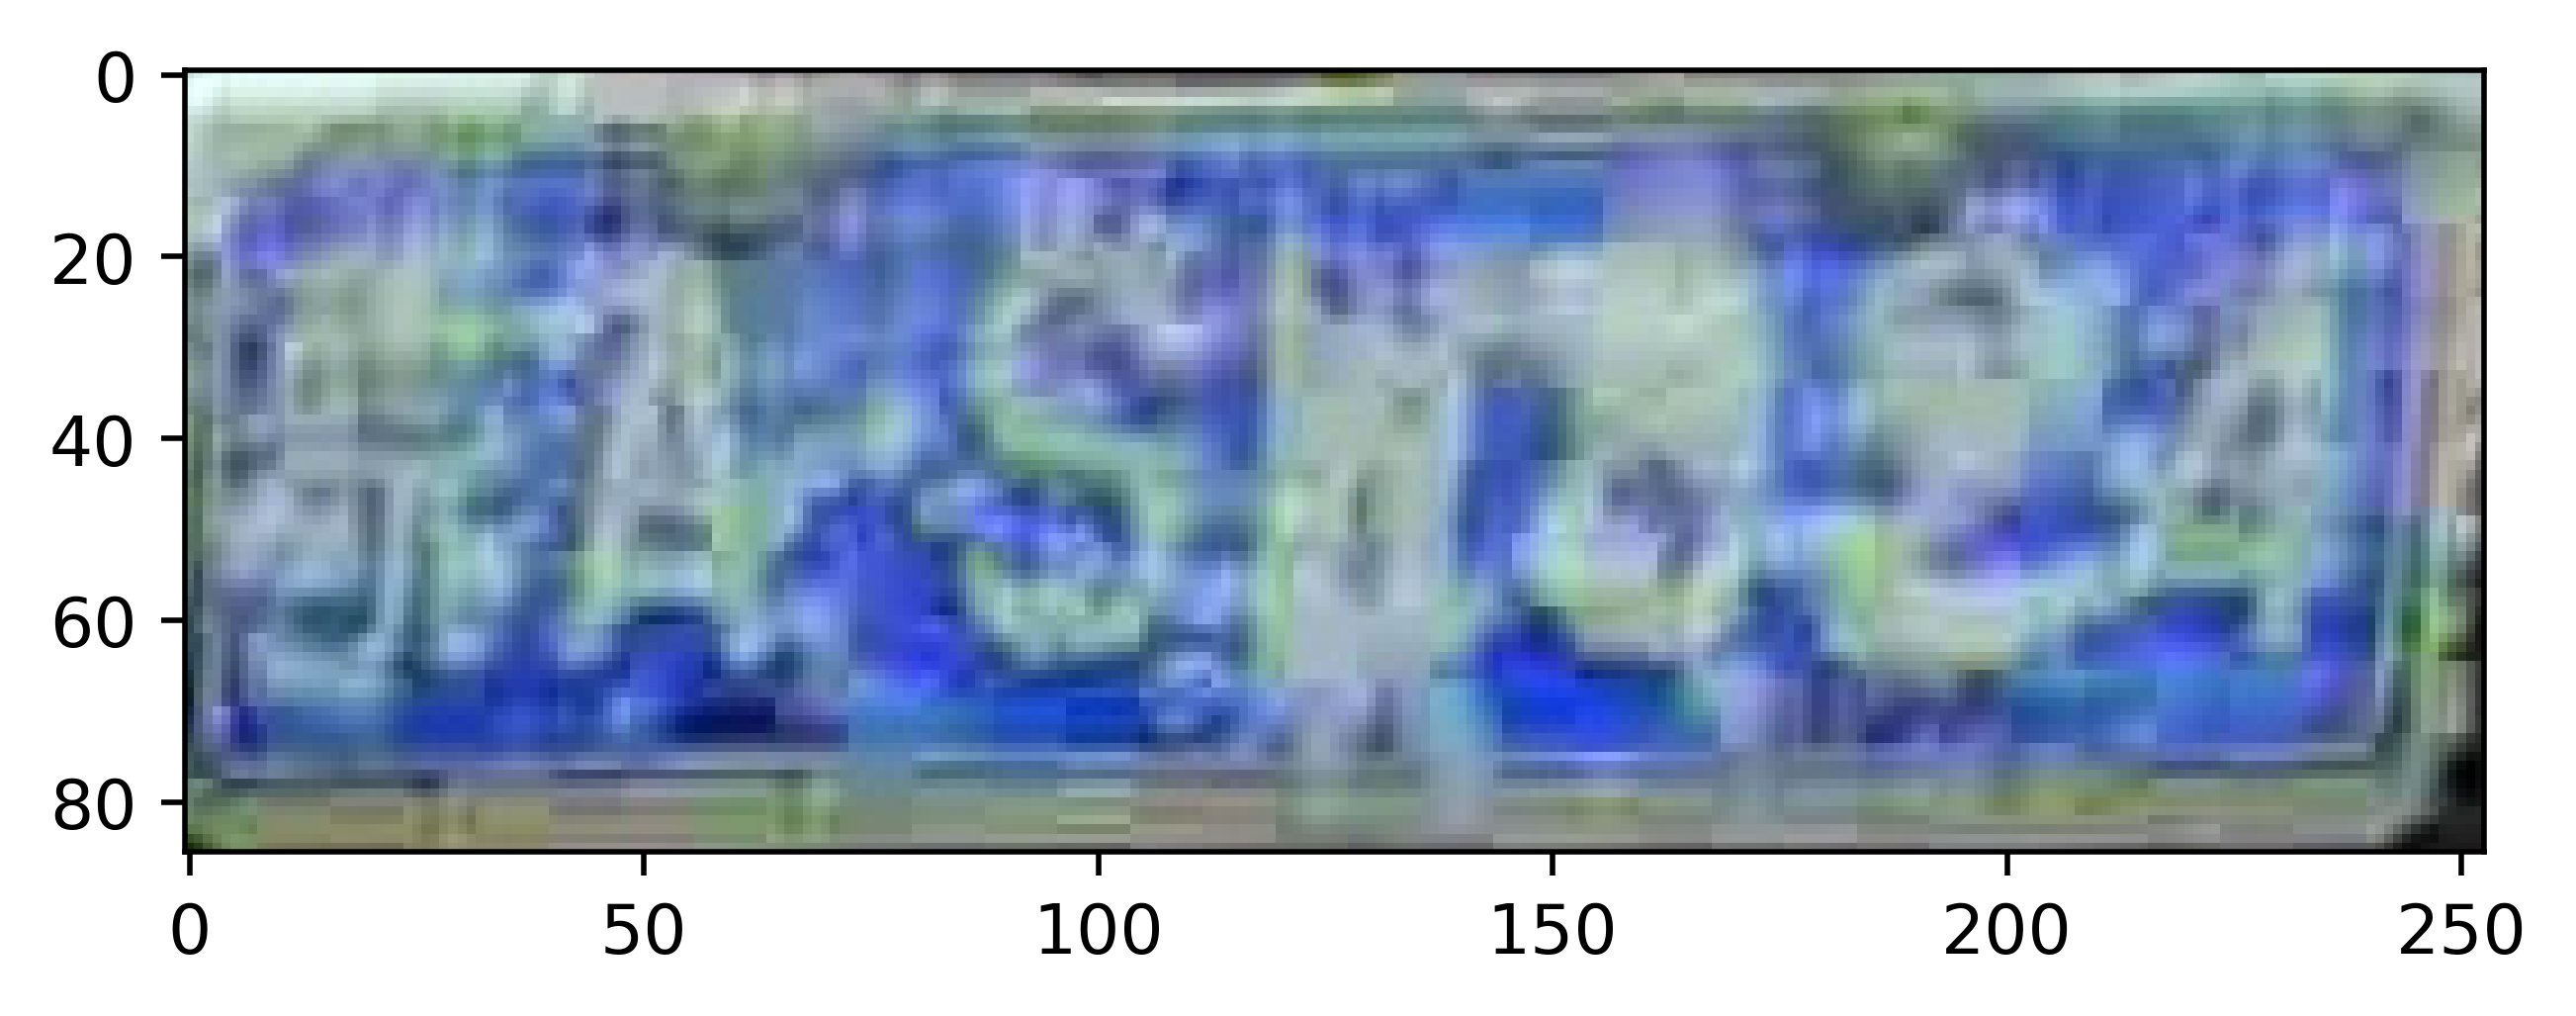

In [ ]:
plt.imshow(Image.open(err_pic[1]))

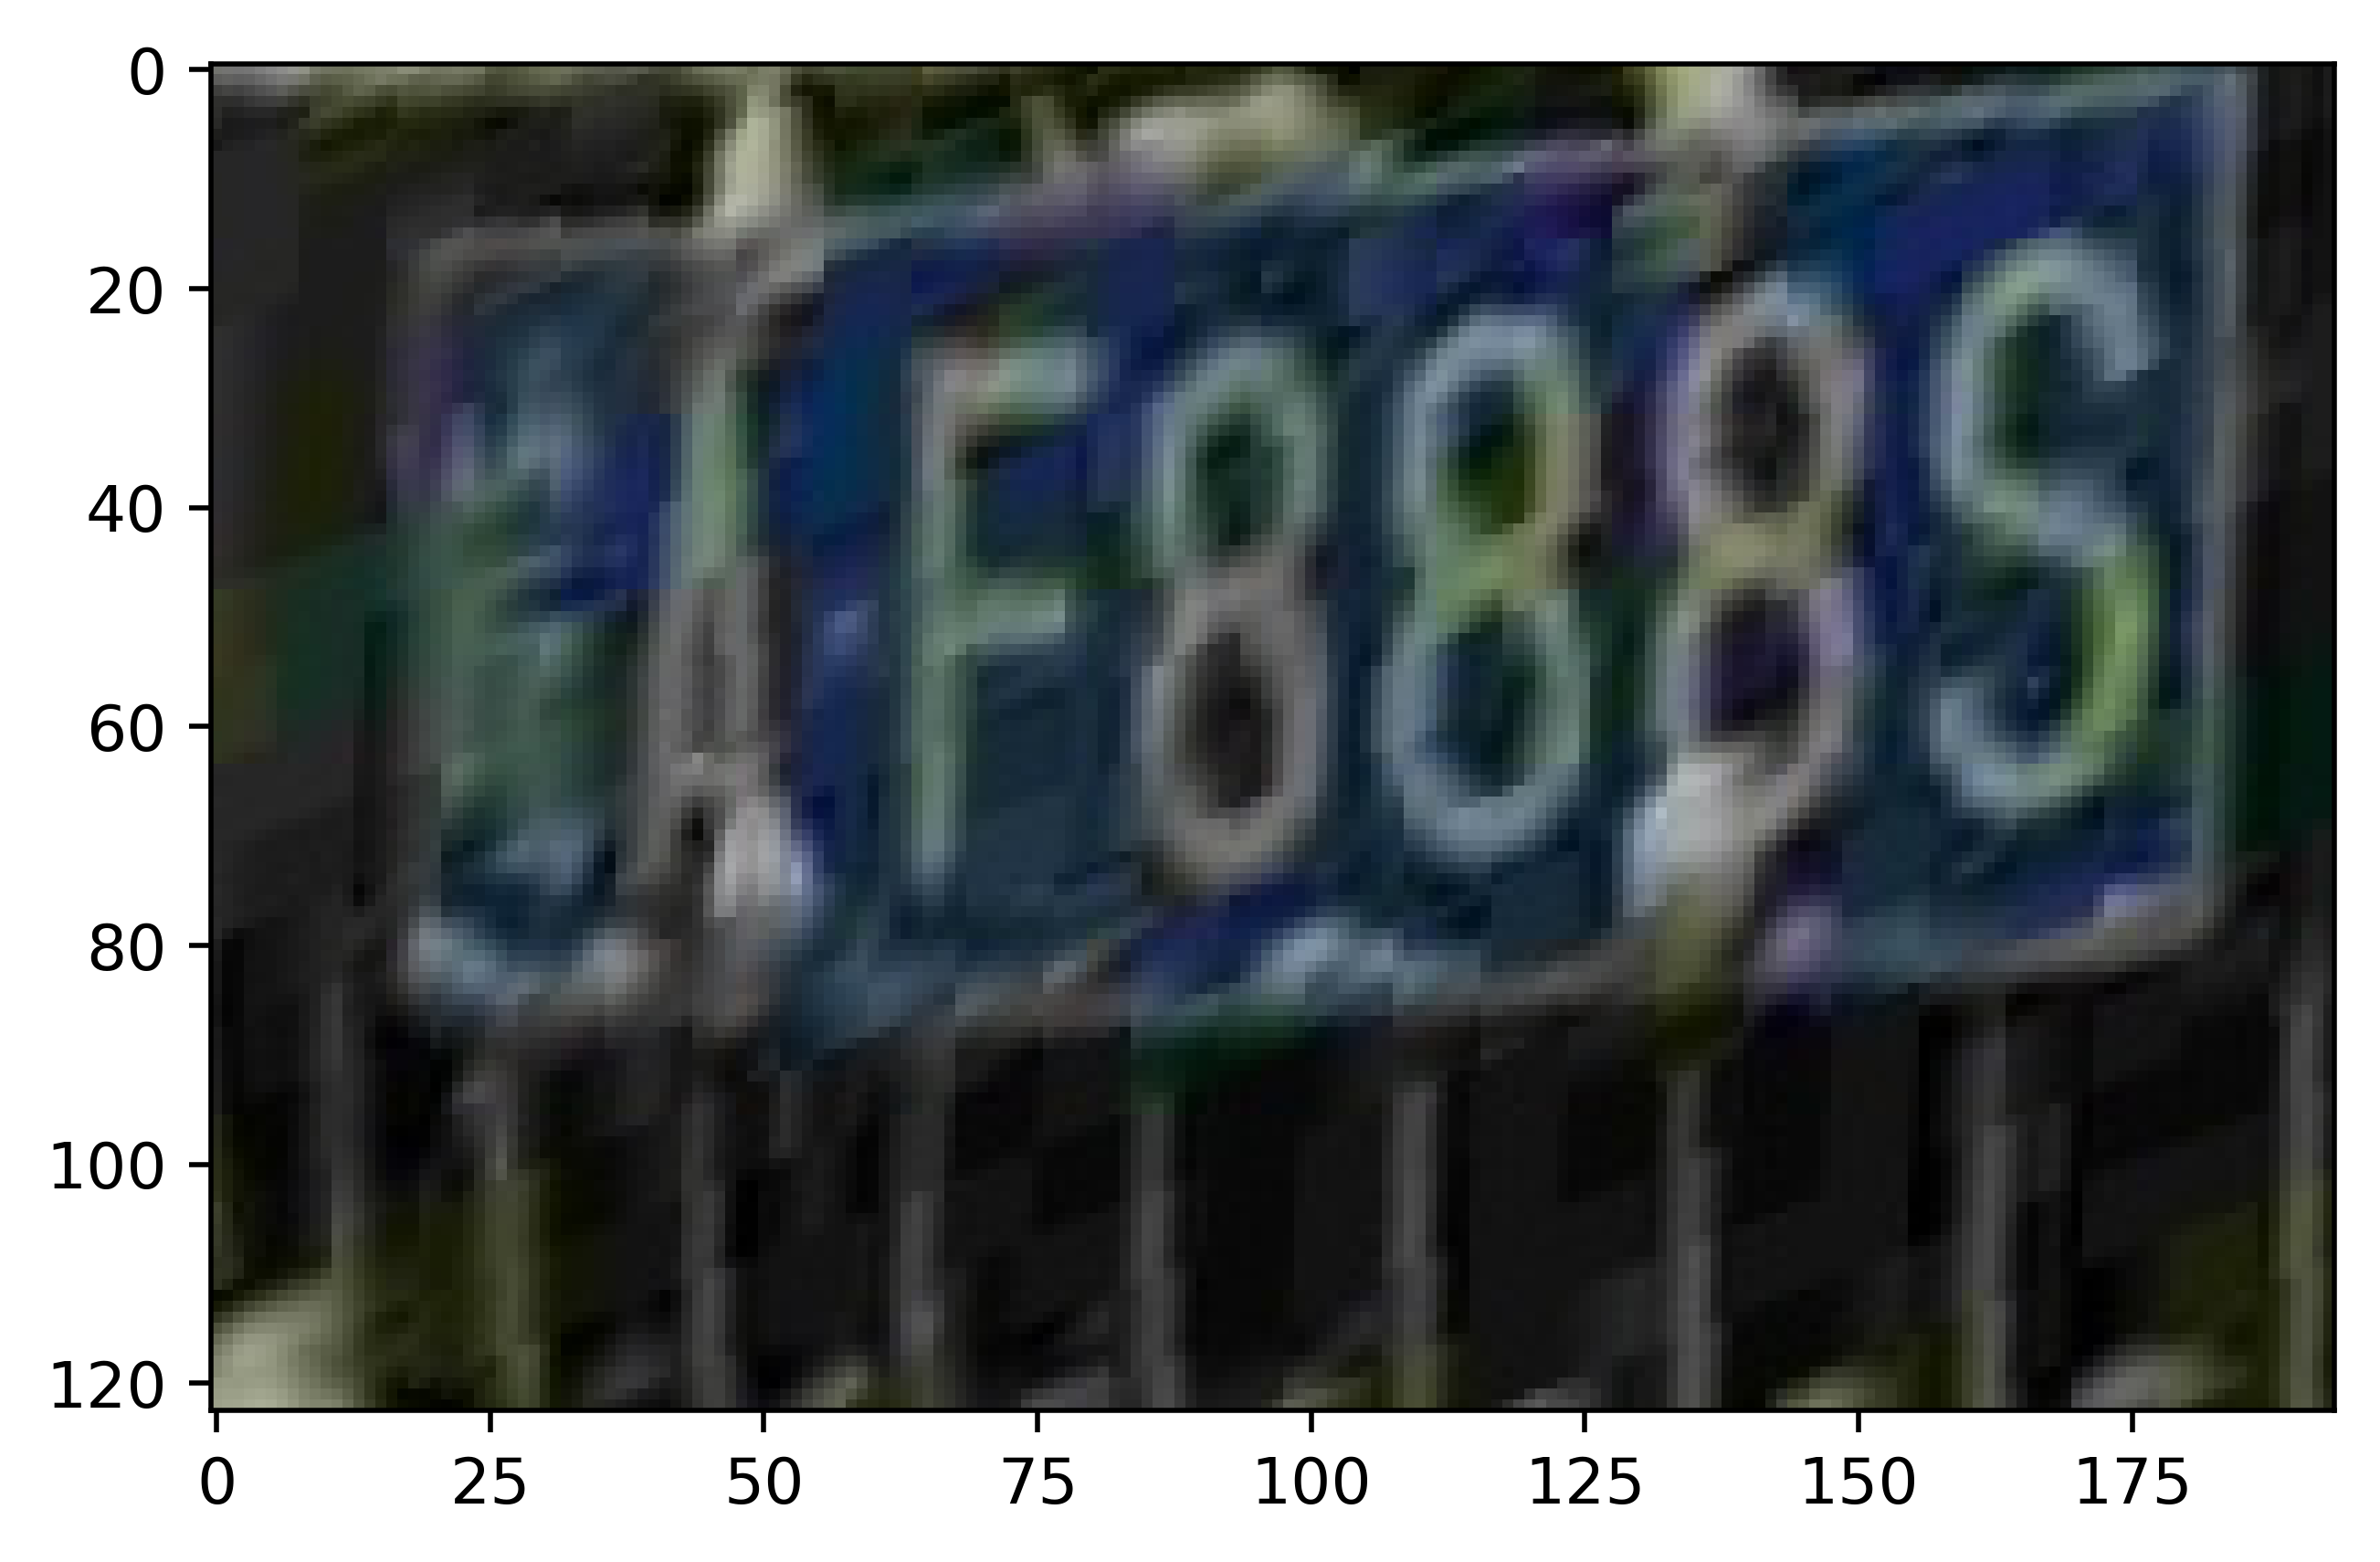

In [ ]:
plt.imshow(Image.open(err_pic[2]))

1) чтобы улучшить скор модели стоит сделать больше размер батча

2) можно затемнить картинки и обучить модель на изобрадениях в градациях серого